**Description**: Simulation check for math in [my answer on stats.stackexchange.com](https://stats.stackexchange.com/a/570680) that there's a way to select a model w/ the best test set performance while also guaranteeing *something* about the selection procedure's performance. Also gives us a sense of how loose the theoretical upper bound is, at least for a particular linear problem.

**Estimated runtime**: 5 min.

**Package requirements**:
```
matplotlib==3.4.3
pandas==1.3.4
scikit-learn==0.24.2
tqdm==4.62.3
```

In [1]:
from __future__ import annotations # in case you're on <= python3.8
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
# globally configure figure and font sizes to be kinda big
plt.rcParams['figure.figsize'] = (10, int(4*(10/6)))
plt.rcParams['font.size'] = 12

In [3]:
def hoeffding_bound(num_models: int,            # m in math
                    max_acceptable_diff: float, # eps in math
                    test_size: int              # n in math
                    ) -> float:
    return 2*num_models * np.exp(-2 * (max_acceptable_diff**2) * test_size)


def simulate(test_size: int,
             num_models: int=2,
             num_simulations: int=20,
             train_size: int=1_000,
             test_size_huge: int=50_000,
             max_acceptable_diff: float=0.01,
             noise: float=0.1,
             random_state: int=None):
    '''
    Simulates the following model selection process `num_simulations` times:
      1. `num_models` models are trained and tuned on a training set with `train_size` examples
      2. Each of these models is evaluated on the test set with `test_size` examples
      3. The model with the highest test set performance is selected

    and returns:
      * observed fraction of `num_simulations` in which the selected model's
        test set error is outside the interval\n
            `(true_error - max_acceptable_diff, true_error + max_acceptable_diff)`
        where `true_error` is the selected model's "true" out-of-sample error.
      * theoretical upper bound on the above fraction.

    Implementation notes:
      * The "true" out-of-sample error is actually just an estimate on a test
        set with `test_size_huge` examples.
      * the classification data is generated via a sparse linear model with some
        flipped labels to allow for greater variance in model errors.
    '''
    # input checks
    if num_models < 1:
        raise ValueError(f'num_models must be at least 1. Got {num_models}.')
    if max_acceptable_diff < 0 or max_acceptable_diff > 1:
        raise ValueError('max_acceptable_diff must be in the interval [0,1]. '
                         f'Got {max_acceptable_diff}.')
    # before looking into any data, compute the upper bound
    frac_oob_ub = hoeffding_bound(num_models, max_acceptable_diff, test_size)
    # simulation
    num_oob_observed: int = 0
    total_size = train_size + test_size + test_size_huge
    for i in range(num_simulations):
        _random_state_data = None if random_state is None else i+random_state
        X, y = make_classification(total_size, flip_y=noise,
                                   random_state=_random_state_data)

        X_tr, X_te_huge, y_tr, y_te_huge = train_test_split(X, y,
                                                            test_size=test_size_huge)
        X_tr, X_te, y_tr, y_te = train_test_split(X_tr, y_tr,
                                                  test_size=test_size)

        # [10^-4, 10^4] is a fine range for make_classification data
        Cs = np.logspace(start=-4, stop=4, num=num_models)

        best_accuracy_obs = -np.inf
        best_model = None
        for j, C in enumerate(Cs):
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore',
                                        message='The max_iter was reached which '
                                                'means the coef_ did not converge')
                _random_state_model = None if random_state is None else j+i+random_state
                model: LogisticRegression = (LogisticRegression(C=C, penalty='l1',
                                                                solver='liblinear',
                                                                random_state=_random_state_model)
                                            .fit(X_tr, y_tr))
            accuracy = model.score(X_te, y_te)
            if accuracy > best_accuracy_obs:
                best_accuracy_obs = accuracy
                best_model = model
        best_accuracy_almost_true = best_model.score(X_te_huge, y_te_huge)
        is_oob = np.abs(best_accuracy_obs - best_accuracy_almost_true) > max_acceptable_diff
        num_oob_observed += is_oob
    return num_oob_observed/num_simulations, frac_oob_ub

In [4]:
num_models = 2

random_state = 43045
num_replications = 10
test_sizes = np.linspace(2_000, 20_000, num=10).astype(int)
_records = []
for test_size in tqdm(test_sizes, desc='Simulating', position=0):
    for _ in tqdm(range(num_replications), leave=False, position=0,
                  desc=f'Replicating n={test_size}, m={num_models}'):
        frac_oob_observed, frac_oob_ub = simulate(test_size, num_models,
                                                  random_state=random_state)
        _records.append({'test set size': test_size,
                         'frac oob (observed)': frac_oob_observed,
                         'frac oob (upper bound)': frac_oob_ub})
sim_results_df = pd.DataFrame(_records)

Simulating:   0%|          | 0/10 [00:00<?, ?it/s]

Replicating n=2000, m=2:   0%|          | 0/10 [00:00<?, ?it/s]

Replicating n=4000, m=2:   0%|          | 0/10 [00:00<?, ?it/s]

Replicating n=6000, m=2:   0%|          | 0/10 [00:00<?, ?it/s]

Replicating n=8000, m=2:   0%|          | 0/10 [00:00<?, ?it/s]

Replicating n=10000, m=2:   0%|          | 0/10 [00:00<?, ?it/s]

Replicating n=12000, m=2:   0%|          | 0/10 [00:00<?, ?it/s]

Replicating n=14000, m=2:   0%|          | 0/10 [00:00<?, ?it/s]

Replicating n=16000, m=2:   0%|          | 0/10 [00:00<?, ?it/s]

Replicating n=18000, m=2:   0%|          | 0/10 [00:00<?, ?it/s]

Replicating n=20000, m=2:   0%|          | 0/10 [00:00<?, ?it/s]

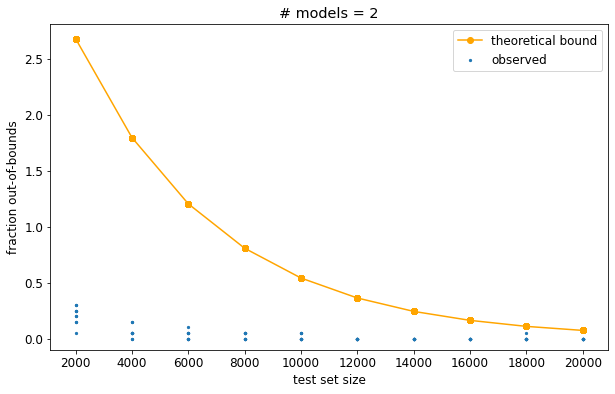

In [5]:
plt.scatter(
    sim_results_df['test set size'],
    sim_results_df['frac oob (observed)'],
    5,
    label='observed')
plt.plot(
    sim_results_df['test set size'],
    sim_results_df['frac oob (upper bound)'],
    label='theoretical bound',
    color='orange',
    marker='o')
plt.ylim(-0.1) # give room for those 0s
plt.legend()
plt.xticks(test_sizes)
plt.title(f'# models = {num_models}')
plt.xlabel('test set size')
plt.ylabel('fraction out-of-bounds');